In [3]:
#Import datasets
from Dataset import Dataset

datasets = [
            "1128e807-b450-436f-a7c7-8970b5273434", # (0) Vessel Arrivals (>75 GT), Monthly
            "19f4c130-4d5d-4d08-9a23-5c8443f7dc51", # (1) Job Vacancy Rate by Industry and Occupational Group, Quarterly
            #"655a1c84-d371-4fb3-81b1-cf80f65b8052", # (2) Short Work-Week & Temporary Layoffs By Industry, Quarterly
            #"64bede5b-353f-4be2-9321-91eadf3f92a2", # (3) Short Work-Week & Temporary Layoffs By Occupational Group, Quarterly
           ]

def main():
    for d,dset in enumerate(datasets):
        datasets[d] = Dataset(dset)
    print("All done!")
        
if __name__ == "__main__":
    main()

[1128e807-b450-436f-a7c7-8970b5273434] Fetching metadata via API
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Fetching data via API
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Parsing metadata
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Parsing data
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Converting data to Pandas DataFrame
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Column "vessel_type" does not appear to be numeric. Pandas says: "Unable to parse string "Tug" at position 0"
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Loaded
[19f4c130-4d5d-4d08-9a23-5c8443f7dc51] Fetching metadata via API
[Job Vacancy by Industry (Level3)] Fetching data via API
[Job Vacancy by Industry (Level3)] Parsing metadata
[Job Vacancy by Industry (Level3)] Parsing data
[Job Vacancy by Industry (Level3)] Converting data to Pandas DataFrame
[Job Vacancy by Industry (Level3)] Column "industry3" does not appear to be numeric. Pandas says: "Unable to parse string "it and other information services" at 

# Data prep

In [5]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from functools import reduce

data = {
    "arr":{
        "df":datasets[0].dataframe[datasets[0].dataframe["vessel_type"] == "Passenger"],
        "label":"Passenger Vessel Arrivals (>75 GT), Monthly"
    },
    "vac":{
        "df":datasets[1].dataframe,
        "label":"Job Vacancy Rate by Industry and Occupational Group, Quarterly"
    },
#    "loi":{
#        "df":datasets[2].dataframe,
#        "label":"Short Work-Week & Temporary Layoffs By Industry, Quarterly"
#    },
#    "log":{
#        "df":datasets[3].dataframe,
#        "label":"Short Work-Week & Temporary Layoffs By Occupational Group, Quarterly"
#    },
}

def dataset_aggregate_by_month(dataset,key,agg_opts = {'gross_tonnage': 'sum', 'month': 'first', 'number_of_vessels': 'sum'}):
    df = dataset["df"].copy()
    #Create aggregated total by month across types/purposes
    return {
        "df": df.groupby(df['month']).aggregate(agg_opts).reset_index(drop=True),
        "label": f'{data[key]["label"]}, Total'
    }
    
def dataset_monthly_to_quarterly(dataset,key):
    df = dataset["df"].copy()
    df["quarter"] = pd.to_datetime(df["month"].map(lambda date: f'{date.year}-{date.quarter * 3:02d}-{date.day:02d}'))
    df = df.groupby(df['quarter']).sum()
    df["quarter"] = df.index
    return {
       "df": df.reset_index(drop=True),
       "label": data[f'{key}']["label"].replace("Monthly","Quarterly")
    }

#Arrivals data appears to double-count (row values for month/tonnage/no. vessels are each repeated twice), so aggregate
data['arr'] = dataset_aggregate_by_month(data['arr'],'arr',{'gross_tonnage': 'first', 'month': 'first', 'number_of_vessels': 'first'})

#Create quarterly passenger arrivals
data['arr_q'] = dataset_monthly_to_quarterly(data['arr'],'arr')

#Sort data by date
for key in data:
    df = data[key]["df"]
    df.sort_values(by=("month" if "month" in df.columns else "quarter"),ascending=True,inplace=True)

#for dataset in data.items():
#    print(f'{dataset[1]["label"]} ({dataset[0]}): {dataset[1]["df"].columns}')



# Charting

## Arrivals, Vessels and Tonnage by Type

{'fig': <Figure size 360x288 with 3 Axes>,
 'ax': array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)}

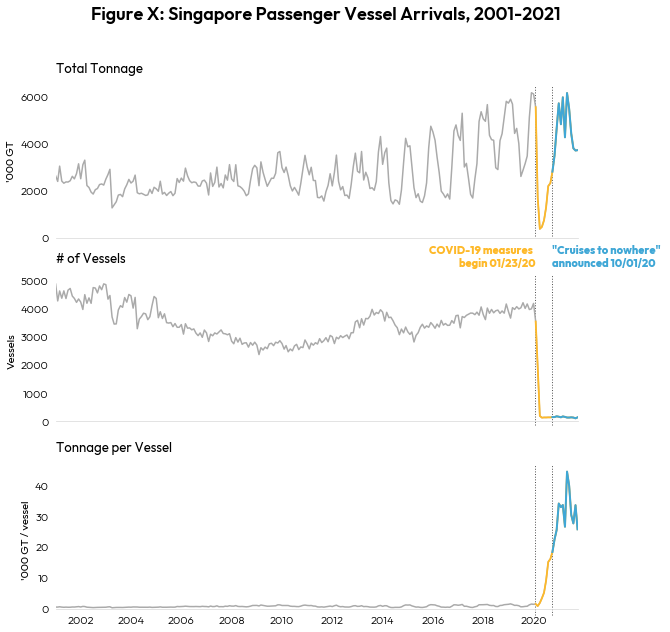

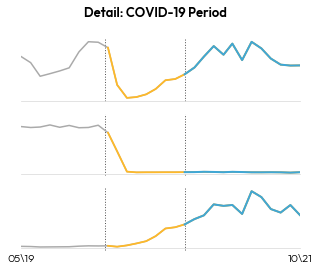

In [12]:
import re
import matplotlib.dates as mdates

df = {}
dates = {
    "covid_data": pd.to_datetime("2020-01-23"),
    "covid": pd.to_datetime("2020-01-23"),
    "cruise": pd.to_datetime("2020-10-01"),
    "covid_min": pd.to_datetime("2019-05-01"),
    "min": pd.to_datetime("2001-01-01"),
    "max": pd.to_datetime("2021-10-01")
}
colors = {
    "lighter":"#ddd",
    "light":"#aaa",
    "dark":"#555",
    "covid":"#feb929",
    "cruise":"#3FA7D6"
}
labels = {
    "title":f'Figure X: Singapore Passenger Vessel Arrivals, {dates["min"].year}-{dates["max"].year}',
    "title_covid":f'Detail: COVID-19 Period',
    "covid":f'COVID-19 measures \nbegin {dates["covid"]:%m/%d/%y}',
    "cruise":f'"Cruises to nowhere" \nannounced {dates["cruise"]:%m/%d/%y}'
}
ts = []

#Global settings
font_files = matplotlib.font_manager.findSystemFonts(fontpaths='./fonts/', fontext='ttf')
for font_file in font_files:
    matplotlib.font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Outfit"
plt.rcParams["font.weight"] = "300"
plt.rcParams["font.size"] = "11"

def setup(plots,title,is_inset):
    
    #Data setup
    df["arr"] = data["arr"]["df"]
    df["arr"]["tonnage_per_vessel"] = df["arr"]["gross_tonnage"] / df["arr"]["number_of_vessels"]
    df["arr_covid"] = df["arr"][df["arr"]["month"] >= dates["covid_data"]]
    df["arr_cruise"] = df["arr"][df["arr"]["month"] >= dates["cruise"]]
    
    #Chart setup
    plot = {}
    plot["fig"], plot["ax"] = plt.subplots(len(plots), 1, sharex=True,figsize = (5,4) if is_inset else (10,10))
    plot["fig"].suptitle(title,fontsize=13 if is_inset else 18,fontweight=600)
    plt.xlim([dates["min"],dates["max"]])
    plt.subplots_adjust(wspace=0, hspace=.15)
    
    ts.append(plot)
    return plot

def format_subplot(index,plot,is_inset):
    ax = _get_ax_from_plot(plot,index)
    ax.tick_params(axis='x',bottom=False)
    ax.tick_params(axis='y',left=False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_edgecolor(colors["lighter"])
    ax.spines['bottom'].set_position('zero')
    
    if is_inset:
        ax.set_yticks([])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m\%y'))
        ax.set_xticks([dates["covid_min"],dates["max"]])
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        
        plt.subplots_adjust(hspace=.1)
        
    else:
        
        plt.subplots_adjust(right=.85)
    
def annotate_subplot(ax):
    
    y_min,y_max = ax.get_ylim()
    
    ax.annotate(labels["covid"],
        xy=(dates["covid"], y_max),
        c=colors["covid"],
        weight=800,
        horizontalalignment='right', 
        verticalalignment='bottom',
        )

    ax.annotate(labels["cruise"],
        xy=(dates["cruise"], y_max),
        c=colors["cruise"],
        weight=800,
        horizontalalignment='left', 
        verticalalignment='bottom',
        )
    
def _get_ax_from_plot(plot,index = 0):
    return plot["ax"] if isinstance(plot["ax"],matplotlib.axes.SubplotBase) else plot["ax"][index]
    
def draw_subplot(index,metric,plot,is_inset):
    ax = _get_ax_from_plot(plot,index)
    field_meta_filter = list(filter(lambda field: field["name"] == metric[0],datasets[0].parsed["meta"]["fields"]))
    if len(field_meta_filter):
        field_meta = field_meta_filter[0]
        ax.set_ylabel(field_meta['unit_of_measure'])
    else:
        ax.set_ylabel("'000 GT / vessel")
    ax.plot("month",metric[0],data=df["arr"],color=colors["light"])
    ax.plot("month",metric[0],data=df["arr_covid"],color=colors["covid"],linewidth=1.8)
    ax.plot("month",metric[0],data=df["arr_cruise"],color=colors["cruise"],linewidth=2)
    y_min,y_max = ax.get_ylim()
    ax.vlines(x=[dates["covid"],dates["cruise"]], color=colors["dark"], linestyle=':',ymin=y_min,ymax=y_max,linewidth=1)
    if not is_inset:
        ax.set_title(metric[1],loc='left')

def init_plot(subplots,title,filename,is_inset = False):
    plot = setup(subplots,title,is_inset)

    for index,metric in enumerate(subplots):
        draw_subplot(index,metric,plot,is_inset)
        format_subplot(index,plot,is_inset)
    if not is_inset:
        annotate_subplot(_get_ax_from_plot(plot,1 if len(subplots) > 1 else 0))
    
    plot["fig"].savefig(f'./{filename}.jpg', dpi=300,bbox_inches='tight')
    
    return plot
    
init_plot([("gross_tonnage","Total Tonnage"),("number_of_vessels","# of Vessels"),("tonnage_per_vessel","Tonnage per Vessel")],labels["title"],"figure_x")

dates["min"] = dates["covid_min"]
init_plot([("gross_tonnage","Total Tonnage"),("number_of_vessels","# of Vessels"),("tonnage_per_vessel","Tonnage per Vessel")],labels["title_covid"],"figure_inset",True)

## Passenger arrivals and job vacancies, by industry

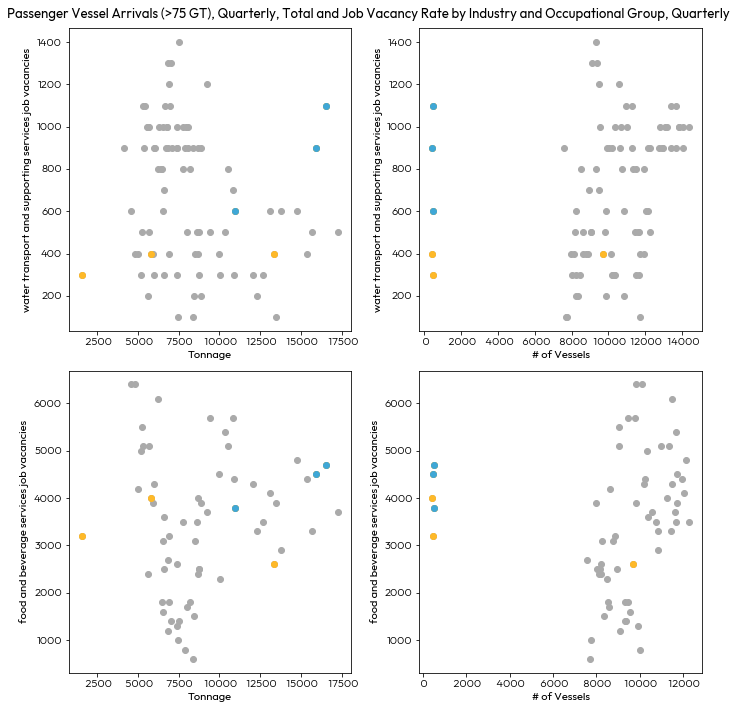

In [4]:
from matplotlib.ticker import FormatStrFormatter

df_arr_vac = data["arr_q"]["df"].merge(data["vac"]["df"],on="quarter")
df_arr_vac_covid = df_arr_vac[df_arr_vac["quarter"] >= dates["covid"]]
df_arr_vac_cruise = df_arr_vac[df_arr_vac["quarter"] >= dates["cruise"]]

#industries = df_arr_vac["industry3"].unique()
industries = ["water transport and supporting services","food and beverage services"]
rows = len(industries)
sc_fig, sc_ax = plt.subplots(rows,2,figsize=(10,10))
sc_fig.suptitle(data["arr_q"]["label"]+" and "+data["vac"]["label"])

row = 0
plots = [("gross_tonnage","Tonnage"),("number_of_vessels","# of Vessels")]
for industry in industries:
    for p,plot in enumerate(plots):
        sc_ax[row][p].scatter(plot[0],"job_vacancy",data=df_arr_vac[df_arr_vac["industry3"] == industry],color=colors["light"])
        sc_ax[row][p].scatter(plot[0],"job_vacancy",data=df_arr_vac_covid[df_arr_vac_covid["industry3"] == industry],color=colors["covid"])
        sc_ax[row][p].scatter(plot[0],"job_vacancy",data=df_arr_vac_cruise[df_arr_vac_cruise["industry3"] == industry],color=colors["cruise"])
        sc_ax[row][p].set_ylabel(f'{industry} job vacancies')
        sc_ax[row][p].set_xlabel(plot[1])
        sc_ax[row][p].xaxis.set_major_formatter(FormatStrFormatter('% .0f'))
    row += 1
sc_fig.tight_layout(pad=1.0)